### Module that includes reading in ACE spacecraft data from https://cdaweb.gsfc.nasa.gov/misc/NotesA.html and back maps the radial/longitude velocity, pressure and density to the inner heliosphere $\sim 30 R_{S}$.


Authors: Opal Issan

Version: Sept 11th, 2022

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy
from scipy import ndimage
from astropy.constants import m_p, k_B
import astropy.units as u
from sunpy.coordinates import frames
from astropy.coordinates import SkyCoord
from sunpy.coordinates.sun import carrington_rotation_time
from heliopy.data import ace
from finite_difference_functions.fd_2d_euler import backward_euler_pizzo_2d, forward_euler_pizzo_2d
from operator_functions.operator_eigenvalues import max_dr_2d
import matplotlib
from tools.interpolate import interpolate_ace_data
import time

plt.rcParams['savefig.facecolor'] = 'white'
font = {'family': 'serif',
        'size': 15}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)

In [7]:
print(carrington_rotation_time(2240))
print(carrington_rotation_time(2241))

2021-01-22 06:31:17.266
2021-02-18 14:42:57.043


### time period

In [8]:
starttime = dt.datetime(year=2021, month=1, day=22)
endtime = dt.datetime(year=2021, month=2, day=18)

### ACE data
### Questions: 
1. How is the bulk velocity computed?
2. What is the temperature tensor? how is the proton temperature vary with respect to the angle of meassurement. 

### Issues: 
1. Longitude velocity is not correct (does not match the velocity magntiude in MAS). 

In [9]:
ACE = ace.swe_h2(starttime, endtime)

In [11]:
# get position of ACE position and measured velocity in 
# Geocentric Solar Ecliptic (GSE) coordinates.
# This system has its X axis towards the Sun and
# its Z axis perpendicular to the plane of the Earth's orbit 
# around the Sun (positive North).
# position (x, y, z)
GSE_X_ACE = ACE.quantity('SC_pos_GSE_0')
GSE_Y_ACE = ACE.quantity('SC_pos_GSE_1')
GSE_Z_ACE = ACE.quantity('SC_pos_GSE_2')
# velocity (vx, vy, vz)
GSE_VX_ACE = ACE.quantity('V_GSE_0')
GSE_VY_ACE = ACE.quantity('V_GSE_1')
GSE_VZ_ACE = ACE.quantity('V_GSE_2')

In [13]:
# define as a astropy skycoord object.
# https://docs.astropy.org/en/stable/coordinates/velocities.html
GSE_COORDS = SkyCoord(x=GSE_X_ACE,
                      y=GSE_Y_ACE, 
                      z=GSE_Z_ACE,
                      v_x=GSE_VX_ACE, 
                      v_y=GSE_VY_ACE, 
                      v_z=GSE_VZ_ACE,
                      representation_type='cartesian',
                      obstime=ACE.index, 
                      frame=frames.GeocentricSolarEcliptic)

In [66]:
# convert to Heliographic Carrington Coordinate system.
# The origin is the center of the Sun.
# The Z-axis (+90 degrees latitude) is aligned with the Sun’s north pole.
# The X-axis and Y-axis rotate with a period of 25.38 days.
# position in spherical (lon, lat, r)
HG_COORDS = GSE_COORDS.transform_to(frames.HeliographicCarrington(observer='sun'))

In [67]:
ACE_longitude = HG_COORDS.lon.to(u.deg).value
ACE_latitude = HG_COORDS.lat.to(u.deg).value
ACE_r = HG_COORDS.radius.to(u.km).value

In [108]:
# velocity in cartesian (linear velocity km/s).
ACE_VX_HG = HG_COORDS.velocity.d_x.to(u.km/u.s).value
ACE_VY_HG = HG_COORDS.velocity.d_y.to(u.km/u.s).value
ACE_VZ_HG = HG_COORDS.velocity.d_z.to(u.km/u.s).value

ACE_X_HG = HG_COORDS.cartesian.x.to(u.km).value
ACE_Y_HG = HG_COORDS.cartesian.y.to(u.km).value
ACE_Z_HG = HG_COORDS.cartesian.z.to(u.km).value

In [118]:
# velocity in spherical (linear velocity km/s).
ACE_VR = HG_COORDS.d_radius.to(u.km / u.s).value  # km/s

Text(0.5, 0, 'Carrington Longitude (Deg.)')

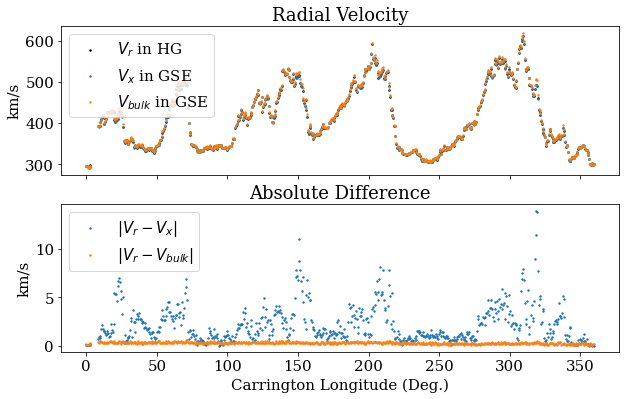

In [158]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 6))

ax[0].scatter(ACE_longitude, ACE_VR, s=2, c="k", label=r"$V_{r}$ in HG")
ax[0].scatter(ACE_longitude, -GSE_VX_ACE, s=2, label=r"$V_{x}$ in GSE")
ax[0].scatter(ACE_longitude, ACE.quantity('Vp'), s=2, label=r"$V_{bulk}$ in GSE")
ax[0].set_ylabel("km/s")
ax[0].set_title("Radial Velocity")
ax[1].scatter(ACE_longitude, np.abs(ACE_VR -ACE.quantity('Vp').value), s=2, label=r"$|V_{r} - V_{x}|$")
ax[1].scatter(ACE_longitude, np.abs(ACE_VR + GSE_VX_ACE.value), s=2, label=r"$|V_{r} - V_{bulk}|$")
ax[0].legend()
ax[1].legend()
ax[1].set_title("Absolute Difference")
ax[1].set_ylabel("km/s")
ax[1].set_xlabel("Carrington Longitude (Deg.)")

In [184]:
ACE_VP_HG = (ACE_VX_HG*ACE_Y_HG - ACE_X_HG*ACE_VY_HG)/(ACE_Y_HG**2 + ACE_X_HG**2)

In [185]:
# THIS IS NOT CORRECT -- VELOCITY SHOULD BE MUCH SMALLER IN MAGNITUDE.
# meaasured in arcsec/ second convert to radians/s and multiply by distance from the sun?
ACE_VP = (HG_COORDS.d_lon.to(u.radian / u.s) * ACE_r).value  # km/s

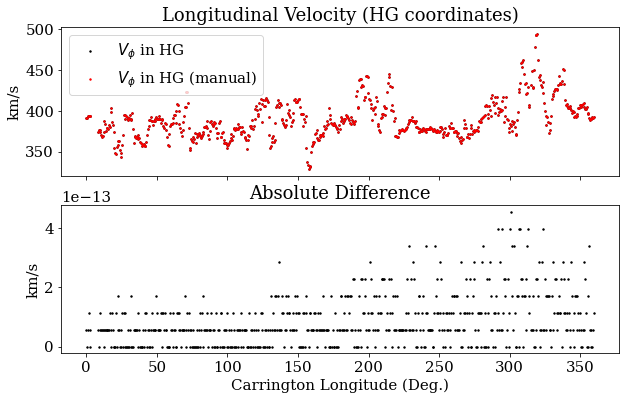

In [186]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 6))

ax[0].scatter(ACE_longitude, -ACE_VP, s=2, c="k", label=r"$V_{\phi}$ in HG")
ax[0].scatter(ACE_longitude, ACE_VP_HG*ACE_r, s=2, c="r", label=r"$V_{\phi}$ in HG (manual)")
ax[1].set_xlabel("Carrington Longitude (Deg.)")
ax[0].set_ylabel("km/s")
ax[1].set_title("Absolute Difference")
ax[0].set_title("Longitudinal Velocity (HG coordinates)")
ax[1].scatter(ACE_longitude, np.abs(ACE_VP_HG*ACE_r+ACE_VP), s=2, c="k", label=r"$|V_{\phi} - V_{manual}|$ in HG")
ax[1].set_ylabel("km/s")
ax[0].legend()

### Interpolate data

In [16]:
p_interp = np.linspace(0, 360, 200)  # in degrees.

In [17]:
# solar wind speed
VR_interp = interpolate_ace_data(x=p_interp, xp=ACE_longitude, fp=ACE_VR, period=360)
VP_interp = interpolate_ace_data(x=p_interp, xp=ACE_longitude, fp=ACE_VP, period=360)
# proton number density
N_interp = interpolate_ace_data(x=p_interp, xp=ACE_longitude, fp=ACE.quantity('Np'), period=360)

# radial component of the proton temperature.
# Q: How does the Tp_{rr} related to isotropic T?
# What is the temperature tensor?
# Note: via A2_K0_MPA we can read in temperatures, parallel & perp.
# for high energy ions or electrons in which T = 1/3 (T|| + 2 T|_)
T_interp = interpolate_ace_data(x=p_interp, xp=ACE_longitude, fp=ACE.quantity('Tpr'), period=360)

In [18]:
# convolve data (smoothing)
kernel_size = 5
kernel = np.ones(kernel_size) / kernel_size
VR_convolved = scipy.ndimage.convolve(VR_interp, kernel, mode='wrap')
VP_convolved = scipy.ndimage.convolve(VP_interp, kernel, mode='wrap')
N_convolved = scipy.ndimage.convolve(N_interp, kernel, mode='wrap')
T_convolved = scipy.ndimage.convolve(T_interp, kernel, mode='wrap')

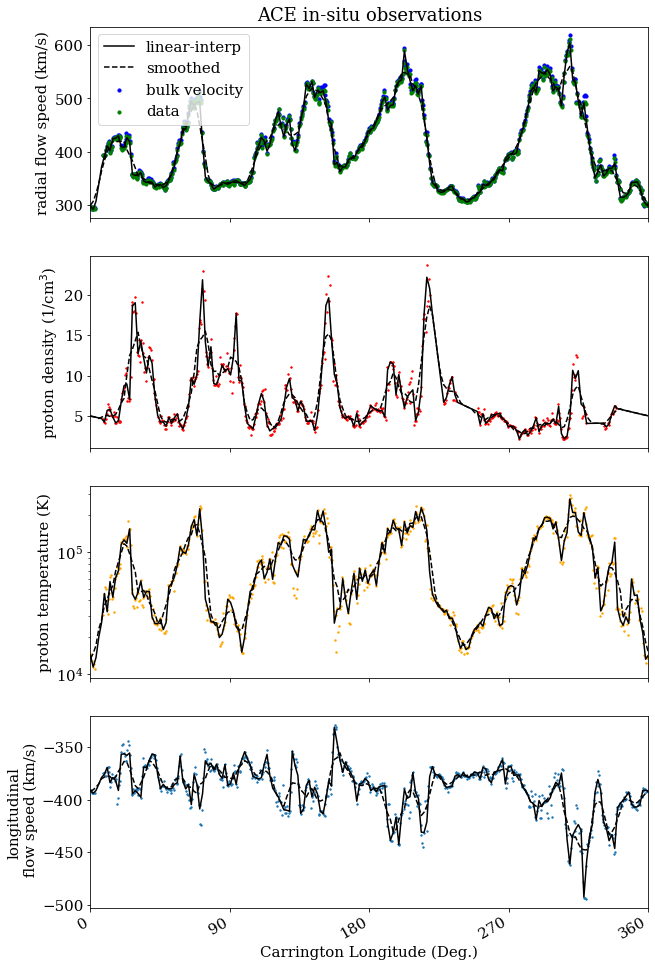

In [23]:
# plot initial condition
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(10, 18))

ax[0].scatter(ACE_longitude, ACE.quantity('Vp'), s=10,c="blue", label="bulk velocity")
ax[0].scatter(ACE_longitude, ACE_VR, s=10, color="g", label="data")
ax[0].plot(p_interp, VR_interp, color="k", label="linear-interp")
ax[0].plot(p_interp, VR_convolved, color="k", ls="--", label="smoothed")
ax[0].legend()

ax[1].scatter(ACE_longitude, ACE.quantity('Np'), s=2, color="r")
ax[1].plot(p_interp, N_interp, color="k")
ax[1].plot(p_interp, N_convolved, color="k", ls="--")

ax[2].scatter(ACE_longitude, ACE.quantity('Tpr'), s=2, color="orange")
ax[2].plot(p_interp, T_interp, color="k")
ax[2].plot(p_interp, T_convolved, color="k", ls="--")

ax[3].scatter(ACE_longitude, ACE_VP, s=2)
ax[3].plot(p_interp, VP_interp, color="k")
ax[3].plot(p_interp, VP_convolved, color="k", ls="--")

ax[0].set_ylabel(r'radial flow speed (km/s)')
ax[1].set_ylabel(r"proton density (1/cm$^3$)")
ax[2].set_ylabel(r"proton temperature (K)")
ax[3].set_ylabel("longitudinal\n flow speed (km/s)")
ax[2].set_yscale("log")
ax[3].set_xlabel("Carrington Longitude (Deg.)")
ax[3].set_xticks([0, 90, 180, 270, 360])
ax[2].set_xlim(0, 360)
ax[0].set_title("ACE in-situ observations")
fig.autofmt_xdate()
plt.show()

In [160]:
# convert units to match the governing equations
# density should be mass/volume --> convert from number density by multiplying by the mass of a proton.
N_convolved_ = (N_convolved * m_p / u.cm ** 3).to(u.kg / (u.km ** 3))
# ideal gas law --> pressure = number density * Boltzmann constant *  temperature
# needs further investigation since temp = T_pr which I am not sure what that means physically -
# might use a different law instead of ideal gas.
# coefficient is unclear -- needs testing.
P_convolved_ = 1 / 3 * (N_convolved / u.cm ** 3 * k_B * T_convolved * u.K).to(u.kg / ((u.s ** 2) * u.km))
# P_convolved_ = scipy.ndimage.convolve(P_convolved_, kernel, mode='wrap')

In [188]:
# This might need more investigation, in MAS code seems like vp ranges from [-60, 60] at 1AU.
U_SOL = np.zeros((4, len(p_interp), int(1e4)))
U_SOL[:, :, 0] = np.array([
    VR_convolved,
    N_convolved_,
    P_convolved_,
    0*VP_convolved
])

In [189]:
# set theta slice and r0.
theta_avg = np.mean(ACE_latitude * u.deg).to(u.rad).value + np.pi / 2
r_vec = np.zeros(int(1e4))
r_vec[0] = np.min(ACE_r)


In [190]:
for ii in range(len(r_vec) - 1):
    # CFL condition for adaptive radial stepping
    dr = 0.85 * max_dr_2d(U=U_SOL[:, :, ii],
                          r=r_vec[ii],
                          dp=(p_interp[1] - p_interp[0]) * (np.pi / 180),
                          theta=theta_avg)

    # update r_vec
    r_vec[ii + 1] = r_vec[ii] - dr

    # stop if r < 30RS
    if r_vec[ii + 1] <= ((30 * u.solRad).to(u.km)).value:
        if r_vec[ii] <= ((30 * u.solRad).to(u.km)).value:
            break
        else:
            r_vec[ii + 1] = ((30 * u.solRad).to(u.km)).value
    elif not np.isfinite(r_vec[ii + 1]):
        raise ArithmeticError
        break

    U_SOL[:, :, ii + 1] = backward_euler_pizzo_2d(U=U_SOL[:, :, ii],
                                                  dr=np.abs(dr),
                                                  dp=(p_interp[1] - p_interp[0]) * (np.pi / 180),
                                                  r=r_vec[ii],
                                                  theta=theta_avg)
#     if ii % 15 == 0:
#         fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(5, 10))
#         ax[0].plot(p_interp, U_SOL[0, :, ii], c="r")
#         ax[0].set_ylabel(r'$\frac{km}{s}$')
#         ax[0].set_title(r"$v_{r}$")
    
#         ax[1].plot(p_interp, ((U_SOL[1, :, ii] / m_p.value) * (1 / u.km ** 3)).to(1 / u.cm ** 3), c="r")
#         ax[1].set_ylabel(r'$\frac{1}{cm^3}$')
#         ax[1].set_title(r"$n_{p}$")
    
#         pos = ax[2].plot(p_interp, (U_SOL[2, :, ii] * (u.kg / (u.s ** 2 * u.km))).to(u.dyne / (u.cm ** 2)), c="b")
#         ax[2].set_ylabel(r'$\frac{dyne}{cm^2}$')
#         ax[2].set_title(r"$P$")
    
#         pos = ax[3].plot(p_interp, U_SOL[3, :, ii], c="k")
#         ax[3].set_ylabel(r'km/s')
#         ax[3].set_title(r"$v_{\phi}$")
#         ax[3].set_xticks([0, 90, 180, 270, 360])
#         ax[3].set_xlabel(" Carrington Longitude (Deg.)")
#         fig.suptitle("r = " + str(round((r_vec[ii] * (u.km)).to(u.AU).value, 3)) + " AU")
#         plt.tight_layout()
#         # plt.show()
#         plt.savefig("figs/ACE_CR2240/fig_" + str(ii) + ".png", dpi=300)


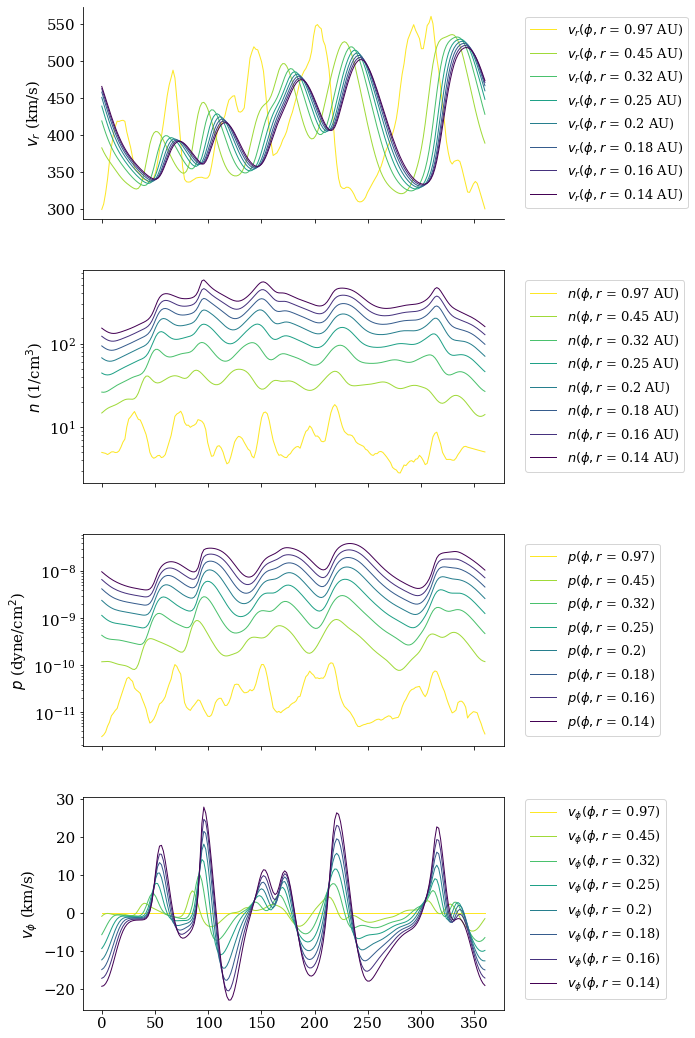

In [191]:

# truncate adaptive stepping
U_SOL = U_SOL[:, :, :ii]
r_vec = r_vec[:ii]

# plot the solution at different radial locations
sample_columns = np.arange(0, len(r_vec), int(len(r_vec) // 7))
# sample_columns = np.append(sample_columns, len(r_vec) - 1)
fig, ax = plt.subplots(4, 1, figsize=(10, 15), sharex=True)

color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

for j in sample_columns:
    curr_color = next(color)
    ax[0].plot(p_interp, U_SOL[0, :, j], color=curr_color, linewidth=1.0,
               label="$v_{r}(\phi, r$ = " + str(round(((r_vec[j] * u.km).to(u.AU)).value, 2)) + " AU)")
    ax[1].plot(p_interp, ((U_SOL[1, :, j] / m_p.value) * (1 / u.km ** 3)).to(1 / u.cm ** 3), color=curr_color,
               linewidth=1.0, label="$n(\phi, r$ = " + str(round(((r_vec[j] * u.km).to(u.AU)).value, 2)) + " AU)")
    ax[2].plot(p_interp, (U_SOL[2, :, j] * (u.kg / ((u.s ** 2) * u.km))).to(u.dyne / (u.cm ** 2)), color=curr_color,
               linewidth=1.0, label="$p(\phi, r$ = " + str(round(((r_vec[j] * u.km).to(u.AU)).value, 2)) + ")")
    ax[3].plot(p_interp, U_SOL[3, :, j], color=curr_color, linewidth=1.0,
               label="$v_{\phi}(\phi, r$ = " + str(round(((r_vec[j] * u.km).to(u.AU)).value, 2)) + ")")

ax[0].set_ylabel(r"$v_{r}$ (km/s)")
ax[1].set_ylabel(r"$n$ (1/cm$^3$)")
ax[2].set_ylabel(r"$p$ (dyne/cm$^2$)")
ax[3].set_ylabel(r"$v_{\phi}$ (km/s)")
ax[0].legend(loc=(1.05, .05), fontsize=13)
ax[1].legend(loc=(1.05, .05), fontsize=13)
ax[2].legend(loc=(1.05, .05), fontsize=13)
ax[3].legend(loc=(1.05, .05), fontsize=13)

ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[2].set_yscale("log")
ax[1].set_yscale("log")
_ = ax[0].tick_params(axis='both', which='major')
plt.tight_layout()
plt.show()
